# Probabilistic Forecasting - Electricity

This notebook demonstrates how to perform Data Visualization with Amazon SageMaker Studio using results taken from the notebook [01-Interactive-Session-Studio](./01-Interactive-Session-Studio.ipynb)

Using this notebook, we can execute cells in order to visualize the aggregations done on data every time new data are available through the scheduled execution of the previous notebook.

**SageMaker Studio Kernel**: Data Science 3.0 - Python 3

Dataset and example taken from [Kaggle](https://www.kaggle.com/code/dimitriosroussis/electricity-price-forecasting-with-dnns-eda/notebook#2.-Visualizations-and-Time-Series-Analysis).

***

# Step 1 - Import modules

In [2]:
import boto3
import csv
import datetime
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sagemaker
import seaborn as sns

In [3]:
s3 = boto3.resource('s3')

In [4]:
sagemaker_session = sagemaker.Session()
region = boto3.session.Session().region_name
role = sagemaker.get_execution_role()
bucket_name = sagemaker_session.default_bucket()

Define where the output data are stored

In [5]:
output_data_path = "<PREFIX_DATA_OUTPUT>"

***

# Step 2 - Visualize results

## Get the last output file produced

In [6]:
bucket = s3.Bucket(bucket_name)

In [7]:
for file in bucket.objects.filter(Prefix=output_data_path):
    print(file)

s3.ObjectSummary(bucket_name='sagemaker-eu-west-1-691148928602', key='electricity-forecasting/data/output/energy_full/_SUCCESS')
s3.ObjectSummary(bucket_name='sagemaker-eu-west-1-691148928602', key='electricity-forecasting/data/output/energy_full/part-00000-7b8d8d99-ea95-4db4-aecb-e494e3d4f6dc-c000.csv')


In [8]:
files = []

for file in bucket.objects.filter(Prefix=output_data_path):
    if file.key.endswith(".csv"):
        files.append(file)
        
files = [obj.key for obj in sorted(files, key=lambda x: x.last_modified, reverse=True)]

In [9]:
df_final = pd.read_csv(f"s3://{bucket_name}/{files[0]}")

## Plot series function

In [10]:
def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

/tmp/ipykernel_24482/3601709081.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def plot_series(df=None, column=None, series=pd.Series([]),


## Hourly actual electricity price with the weekly rolling mean

In [11]:
cities = ['barcelona', 'bilbao', 'madrid', 'seville', 'valencia']

for city in cities:
    df_final = df_final.drop(['rain_3h_{}'.format(city)], axis=1)

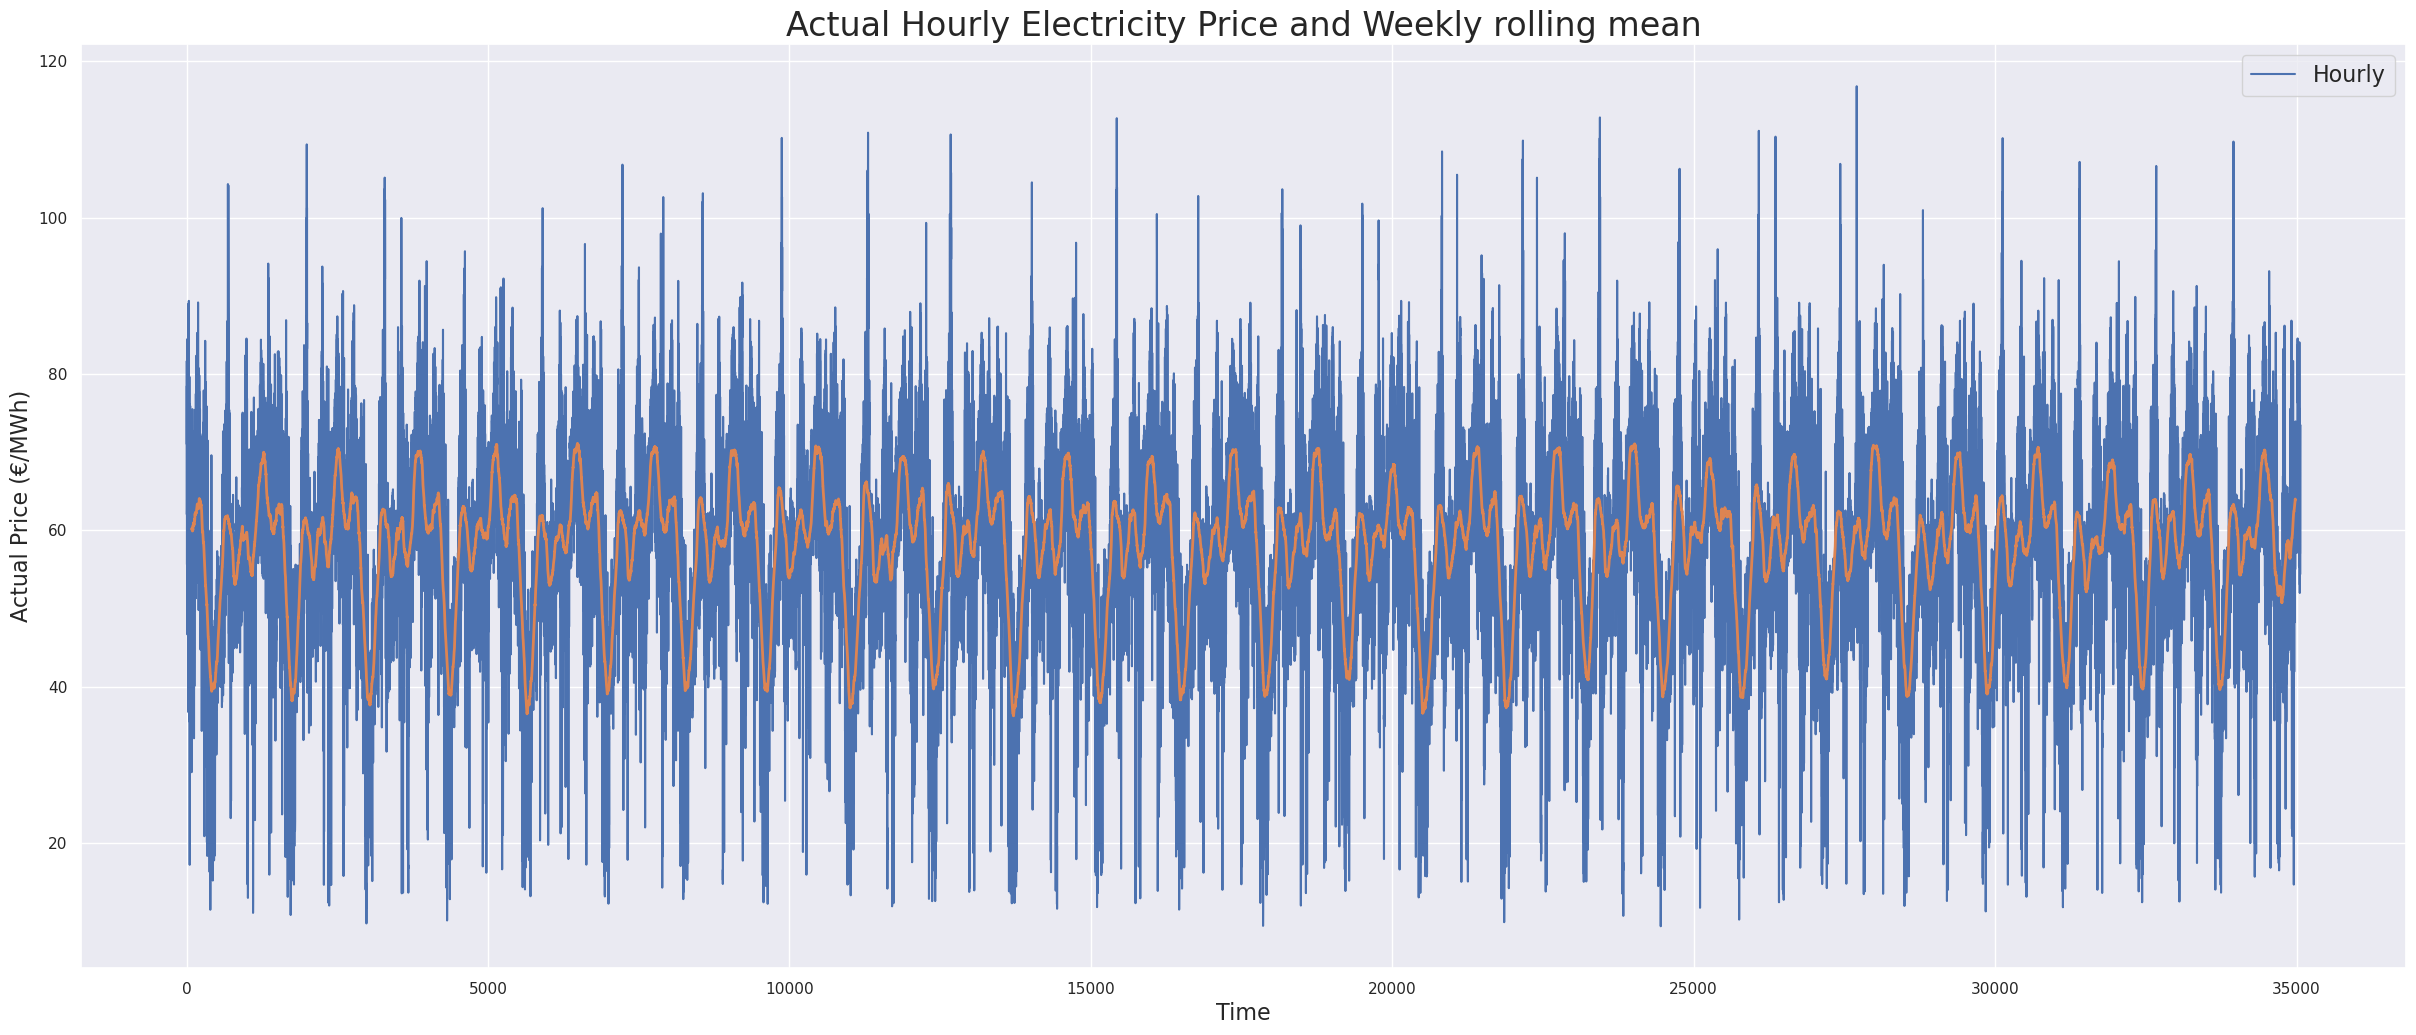

In [12]:
rolling = df_final['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

## Actual electricity price at a daily/weekly scale

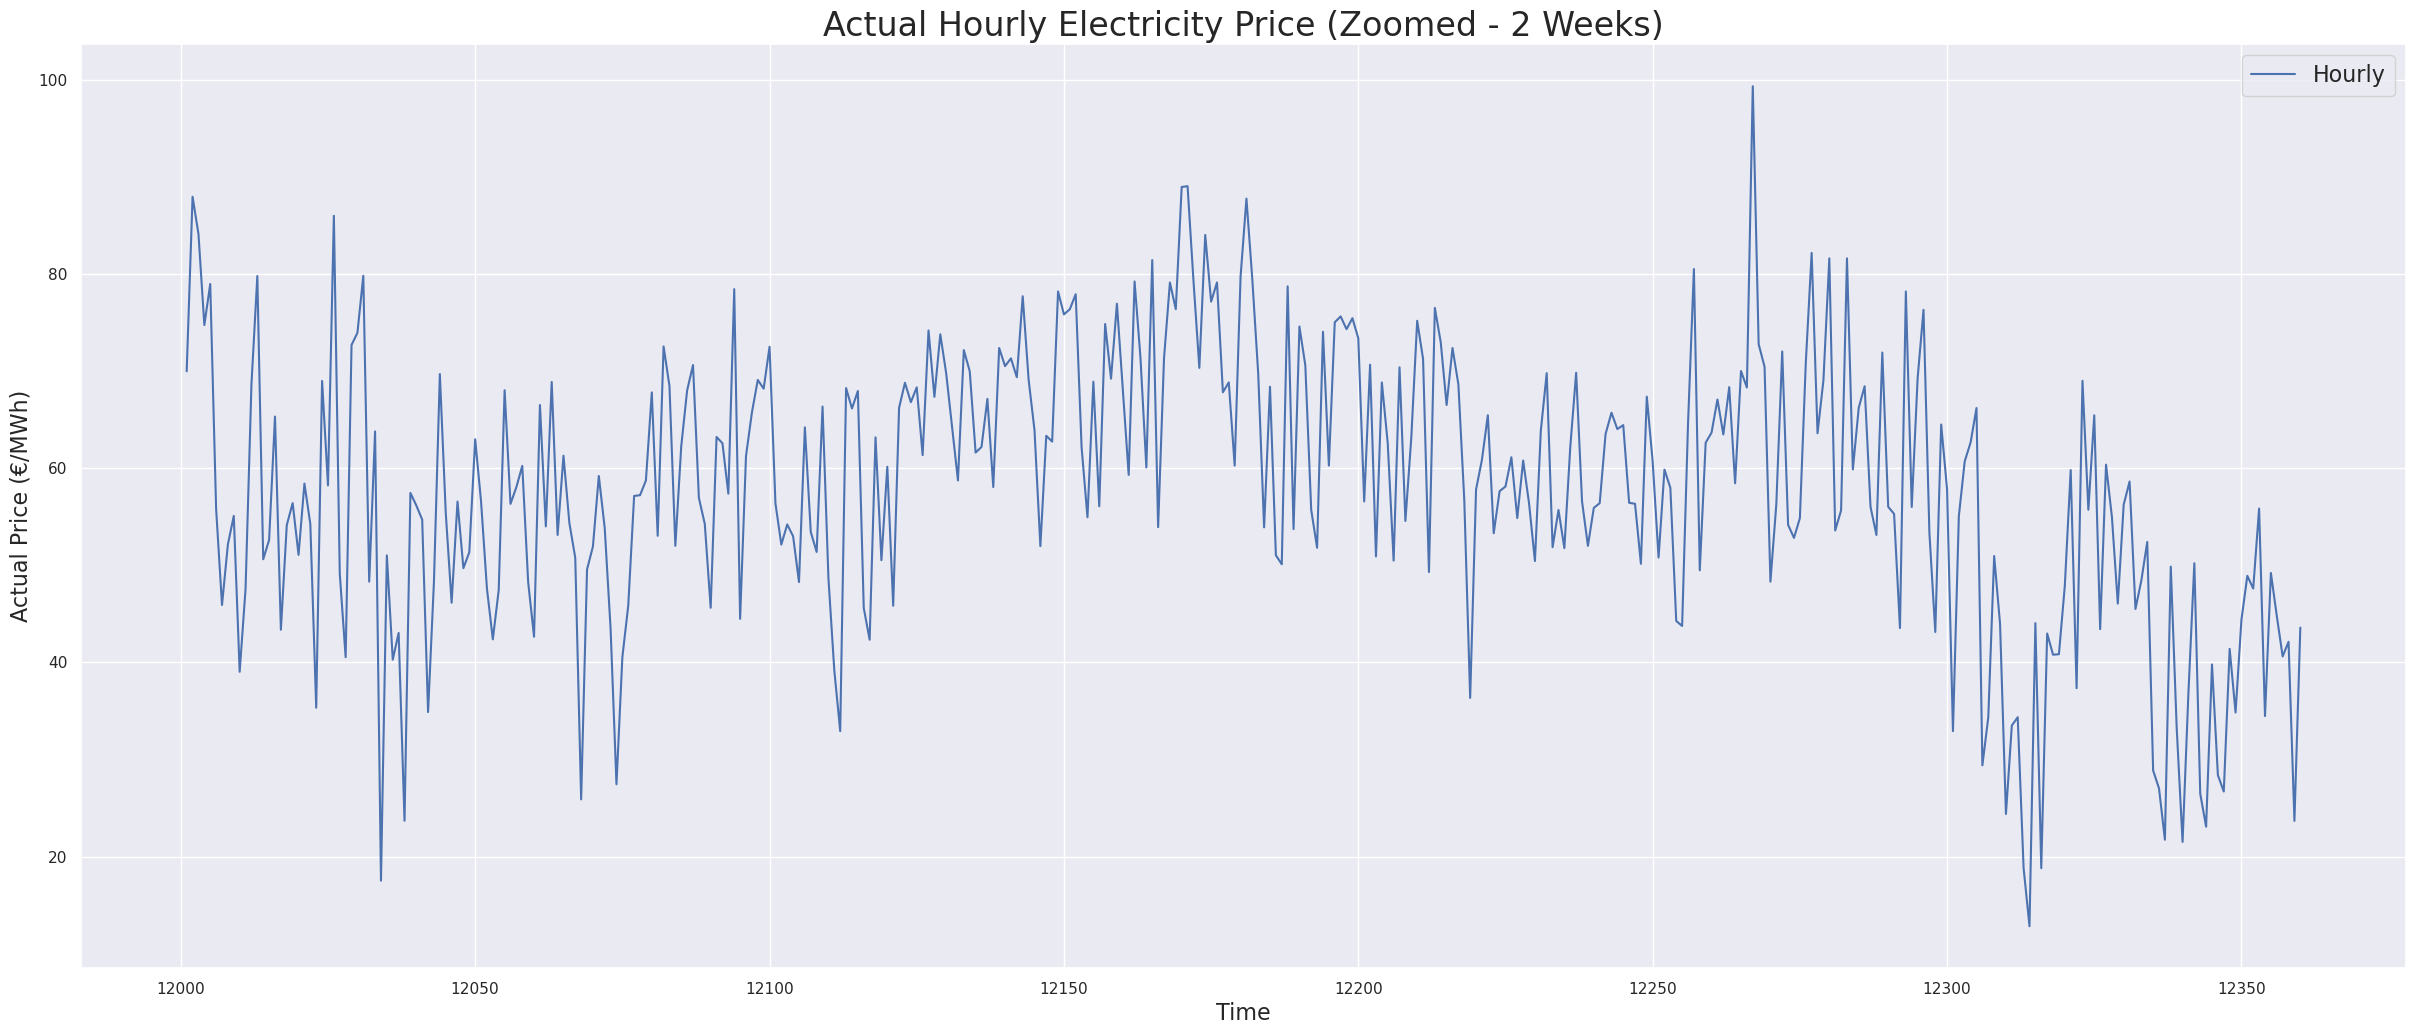

In [13]:
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price (Zoomed - 2 Weeks)')
plt.show()

## Percentage of the hourly change in the actual electricity price

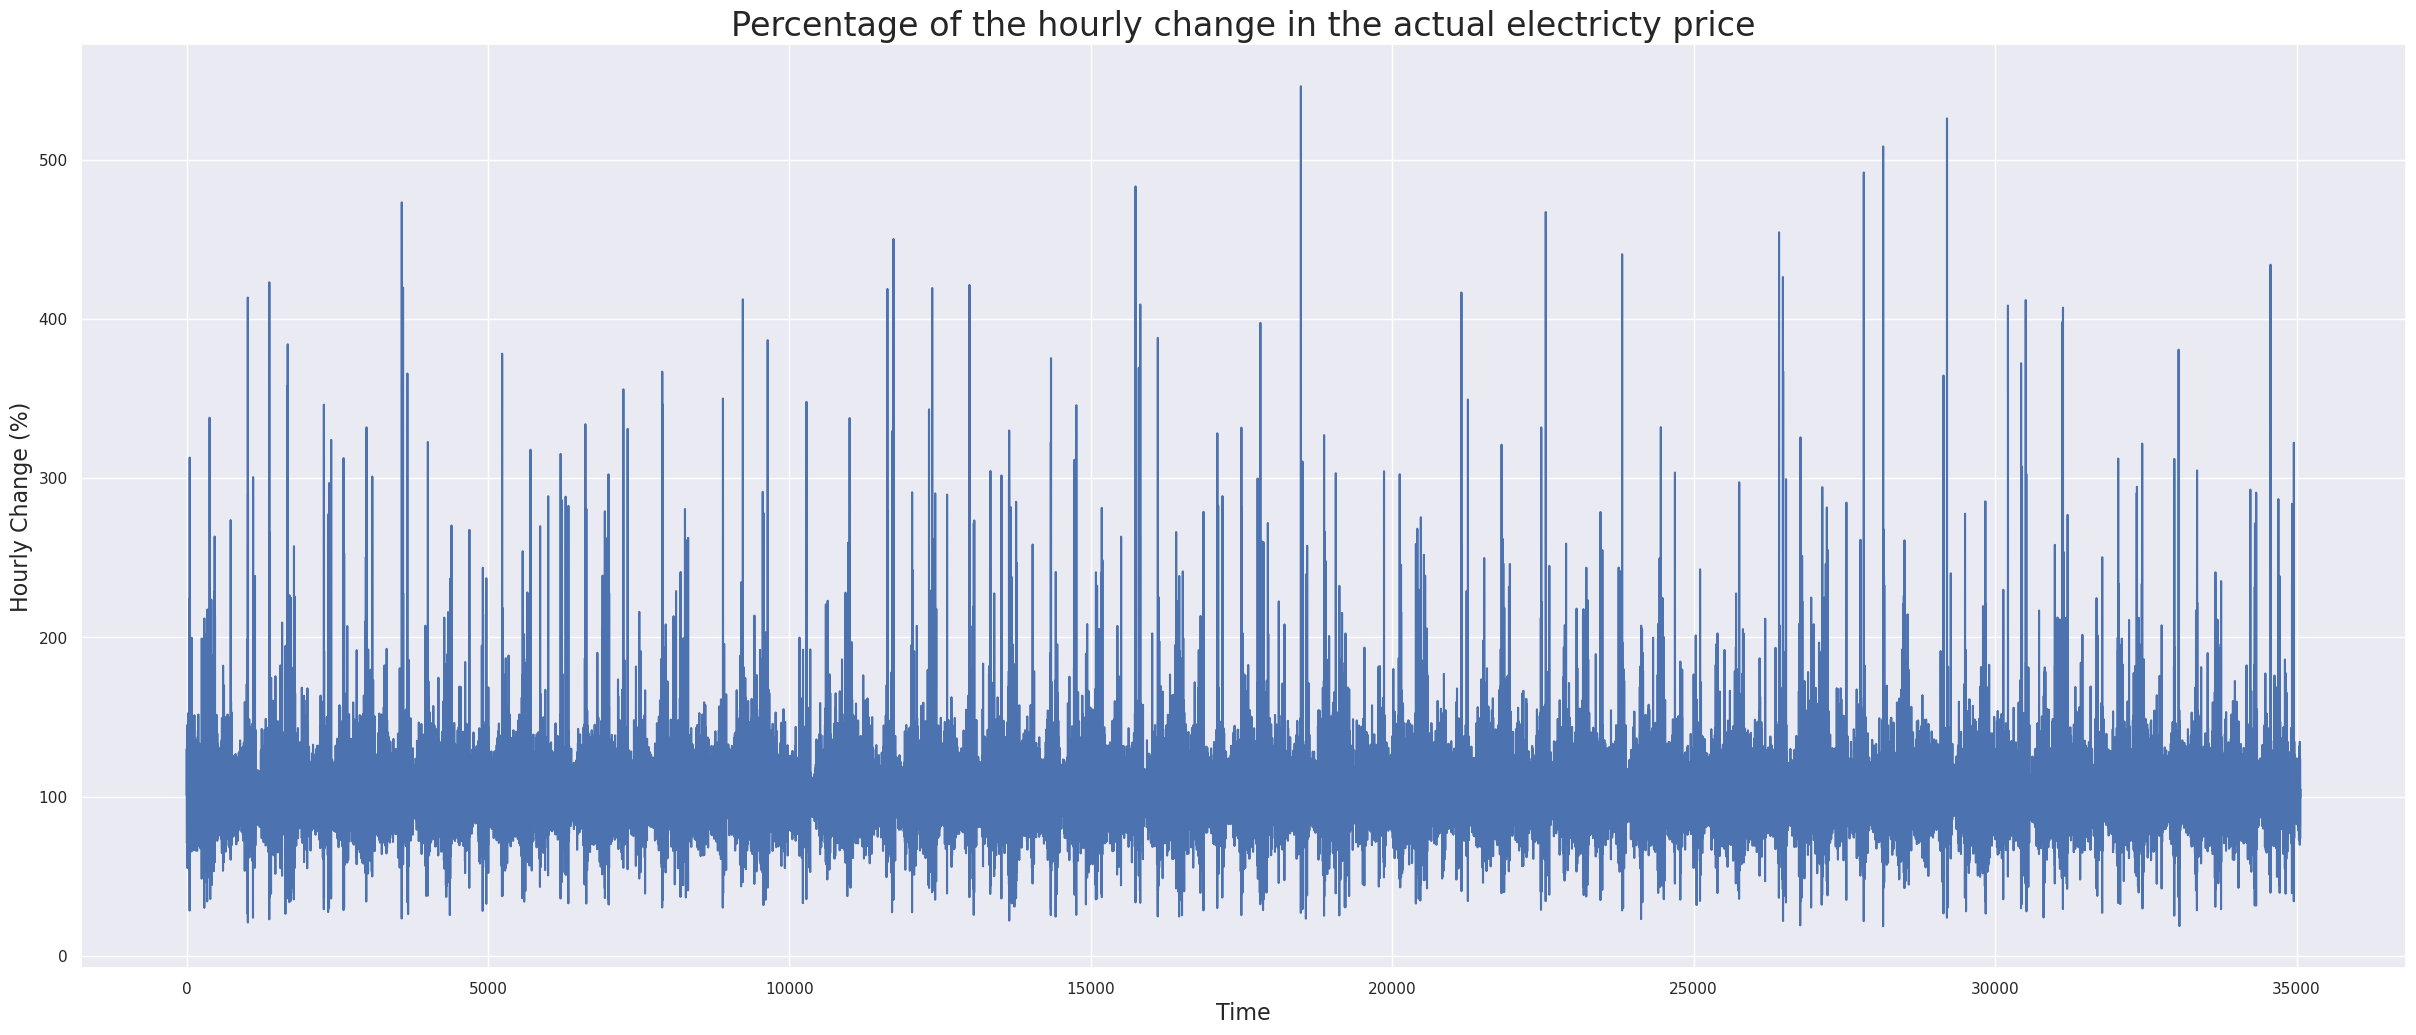

In [14]:
change = df_final['price actual'].div(df_final['price actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change in the actual electricty price')
plt.show()

## Histogram of the actual electricity price

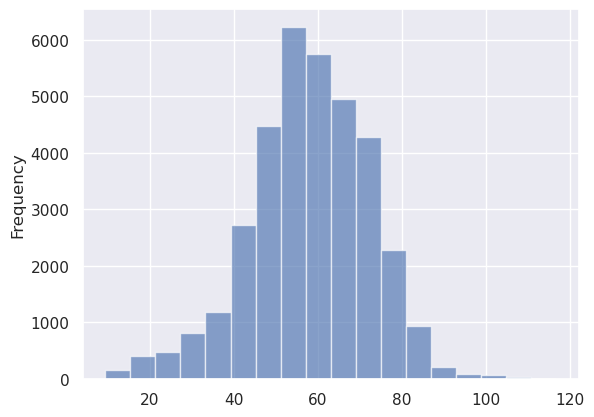

In [15]:
ax = df_final['price actual'].plot.hist(bins=18, alpha=0.65)